# Предобработка

In [54]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import os

# Функция для удаления метаданных и очистки текста
def clean_text_advanced(text):
    # Удалить технические заголовки
    text = re.sub(r'(?i)(message-id|date|from|to|subject|mime-version|content-type|content-transfer-encoding|x-[\w\-]+):.*?(?=\n|$)', '', text)

    # Удалить все email-адреса
    text = re.sub(r'\S+@\S+', '', text)

    # Удалить URL
    text = re.sub(r'http\S+', '', text)

    # Удалить номера телефонов
    text = re.sub(r'\(?\d{3}\)?[-.\s]?\d{3}[-.\s]?\d{4}', '', text)

    # Удалить лишние пустые строки
    text = re.sub(r'\n+', '\n', text)

    # Оставить только тело письма — после двойного переноса строки
    split_parts = text.split('\n\n', 1)
    if len(split_parts) == 2:
        text = split_parts[1]
    
    # Финальная очистка
    text = re.sub(r'\s+', ' ', text)
    return text.strip().lower()
    
# Загружаем данные
df = pd.read_csv('email_dataset/raw_data/emails.csv')

# укажи своё название столбца, где находится исходный текст с метаданными
text_column = 'message'  # например

# Удаляем строки с пустым текстом
df = df.dropna(subset=[text_column])

# Применяем улучшенную функцию очистки
df['clean_content'] = df[text_column].apply(clean_text_advanced)

# Разделяем на наборы данных
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
validation_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Сохраняем обработанные данные
for dataset, name in zip([train_df, validation_df, test_df], ['train', 'validation', 'test']):
    os.makedirs(f'email_dataset/{name}/', exist_ok=True)
    dataset.to_csv(f'email_dataset/{name}/{name}_emails.csv', index=False)

print("✅ Данные успешно обработаны и сохранены без метаданных!")


✅ Данные успешно обработаны и сохранены без метаданных!


In [60]:
pwd

'/Users/admin/matrixdna_assigment'

In [62]:
df = pd.read_csv('email_dataset/test/test_emails.csv')


In [63]:
df

,file,message,clean_content
0,shackleton-s/all_documents/11241.,Message-ID: <32750315.1075844755568.JavaMail.e...,"hi sara, i wanted to let you know that i made ..."
1,mann-k/all_documents/3501.,Message-ID: <2206475.1075845661857.JavaMail.ev...,good one. nothing worse than an aimless off site.
2,davis-d/discussion_threads/454.,Message-ID: <5155873.1075853960634.JavaMail.ev...,"cc: bcc: rosemary, after a discussion with sta..."
3,cuilla-m/deleted_items/556.,Message-ID: <1791927.1075863019811.JavaMail.ev...,to view & print you invitation please visit:
4,mann-k/all_documents/1127.,Message-ID: <15410161.1075845602858.JavaMail.e...,"this is an internal draft, which has not been ..."
...,...,...,...
77606,germany-c/inbox/228.,Message-ID: <6690272.1075852115668.JavaMail.ev...,what: workstation upgrade for security enhance...
77607,reitmeyer-j/sent_items/33.,Message-ID: <7953404.1075855171343.JavaMail.ev...,i agree that we should not move the business a...
77608,presto-k/deleted_items/555.,Message-ID: <32822028.1075852822485.JavaMail.e...,______________________________________________...
77609,dasovich-j/sent/11940.,Message-ID: <4910874.1075849611595.JavaMail.ev...,fyi. please keep confidential until further no...


In [80]:
df['message'][3]

'Message-ID: <1791927.1075863019811.JavaMail.evans@thyme>\nDate: Tue, 20 Nov 2001 14:51:48 -0800 (PST)\nFrom: party@kitkat.org\nTo: mcuilla@enron.com\nSubject: Your Kit Kat Invitation\nMime-Version: 1.0\nContent-Type: text/plain; charset=us-ascii\nContent-Transfer-Encoding: 7bit\nX-From: Kit Kat <Party@KitKat.org>\nX-To: <mcuilla@enron.com>\nX-cc: \nX-bcc: \nX-Folder: \\MCUILLA (Non-Privileged)\\Cuilla, Martin\\Deleted Items\nX-Origin: Cuilla-M\nX-FileName: MCUILLA (Non-Privileged).pst\n\nTo view & print you invitation please visit:\n\nhttp://www.kitkat.org/emailblast/KITKAT_BOAKA_INVITE.htm\n\n\n'

In [78]:
df['clean_content'][3]

'to view & print you invitation please visit:'

# Классификация 

In [91]:
# !pip install openai python-dotenv scikit-learn matplotlib tqdm

In [3]:
import os
import openai
import pandas as pd
import numpy as np
from tqdm import tqdm
from dotenv import load_dotenv

# Загрузка API-ключа
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")
client = openai.OpenAI(api_key=api_key)

# Загрузка подвыборки
df = pd.read_csv("email_dataset/train/train_emails.csv")
texts = df["clean_content"].dropna().sample(n=1000, random_state=42)

# Сохраняем соответствие текста и индекса
texts.reset_index(drop=True, inplace=True)
texts_list = texts.tolist()

# Получение эмбеддингов
print("📡 Получаем эмбеддинги...")
embeddings = []

for text in tqdm(texts_list):
    try:
        response = client.embeddings.create(
            input=text[:2000],
            model="text-embedding-ada-002"
        )
        embeddings.append(response.data[0].embedding)
    except Exception as e:
        print(f"⚠️ Ошибка: {e}")
        embeddings.append([0.0] * 1536)

# Сохраняем как .npy и .csv
np.save("email_dataset/train/embeddings_subset.npy", np.array(embeddings))
texts.to_csv("email_dataset/train/texts_subset.csv", index=False)

print("✅ Эмбеддинги и тексты сохранены!")


📡 Получаем эмбеддинги...


100%|██████████| 1000/1000 [05:47<00:00,  2.88it/s]


✅ Эмбеддинги и тексты сохранены!


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Загрузка эмбеддингов
embeddings = np.load("email_dataset/train/embeddings_subset.npy")
texts = pd.read_csv("email_dataset/train/texts_subset.csv")

# График локтя
print("📈 Строим график локтя...")
inertias = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, marker='o')
plt.title("Метод локтя (OpenAI Embeddings + KMeans)")
plt.xlabel("Количество кластеров (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.tight_layout()
plt.show()

# Дополнительно: сохраним модель KMeans с выбранным k
k_opt = 4  # Задай вручную после графика
final_kmeans = KMeans(n_clusters=k_opt, random_state=42)
texts["cluster"] = final_kmeans.fit_predict(embeddings)
texts.to_csv("email_dataset/train/texts_with_clusters.csv", index=False)

from joblib import dump
dump(final_kmeans, "models/kmeans_openai_embeddings.joblib")

print("✅ Кластеры сохранены. Модель KMeans сохранена в models/")


In [9]:
import pandas as pd

# Загрузка данных с кластерами
df = pd.read_csv("email_dataset/train/texts_with_clusters.csv")

# Подсчёт количества примеров в каждом кластере
cluster_counts = df["cluster"].value_counts().sort_index()

# Вывод результата
print("📊 Количество писем в каждом кластере:\n")
for cluster_id, count in cluster_counts.items():
    print(f"🟦 Кластер {cluster_id}: {count} писем")


📊 Количество писем в каждом кластере:

🟦 Кластер 0: 59 писем
🟦 Кластер 1: 105 писем
🟦 Кластер 2: 56 писем
🟦 Кластер 3: 117 писем
🟦 Кластер 4: 98 писем
🟦 Кластер 5: 92 писем
🟦 Кластер 6: 72 писем
🟦 Кластер 7: 78 писем
🟦 Кластер 8: 72 писем
🟦 Кластер 9: 103 писем
🟦 Кластер 10: 73 писем
🟦 Кластер 11: 75 писем


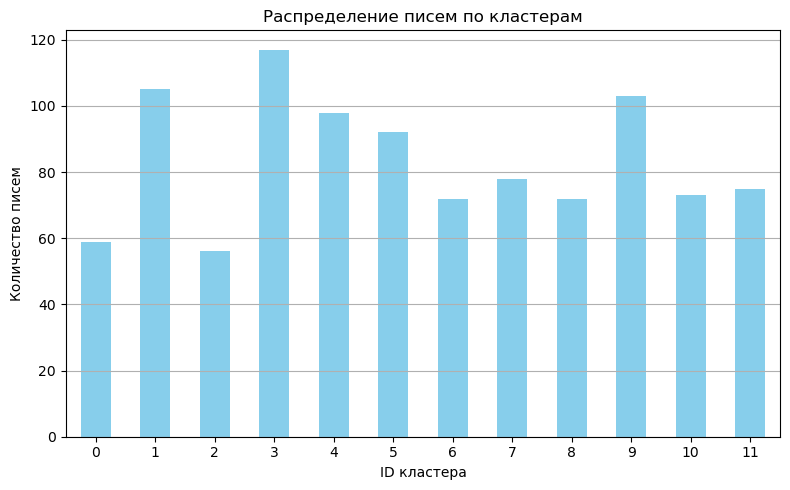

In [11]:
import matplotlib.pyplot as plt

cluster_counts.plot(kind='bar', figsize=(8, 5), color='skyblue')
plt.title("Распределение писем по кластерам")
plt.xlabel("ID кластера")
plt.ylabel("Количество писем")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [21]:
import pandas as pd

# Загрузка размеченных кластеров
df = pd.read_csv("email_dataset/train/texts_with_clusters.csv")

# Количество примеров для просмотра
n_samples = 3

for cluster_id in sorted(df["cluster"].unique()):
    print(f"\n🟦 Кластер {cluster_id}")
    sample_texts = df[df["cluster"] == cluster_id]["clean_content"].sample(n=n_samples, random_state=15)
    for i, text in enumerate(sample_texts, 1):
        print(f"  📩 Пример {i}: {text[:1000]}...\n")


🟦 Кластер 0
  📩 Пример 1: trading credit legal legal houston cc: bcc: there will be two presentations tomorrow from ubs commencing at 2:30 p.m. (cst). these will be held in ecs 06980 and the conference dial-in numbers are listed below. 2:30 p.m. bill glass & bill bradford - credit 3:00 p.m. alex fusco - new business guidelines dial-in # host code 353763 (louise) participant 547763 many thanks, liz taylor assistant to greg whalley office fax mobile...

  📩 Пример 2: chris--fyi--are you available for a meeting thursday, march 30 at 11:00 a.m. to discuss these issues? if so, will you ask kim to get a room for us for about an hour? thanks. ---------------------- forwarded by colleen sullivan/hou/ect on 03/28/2000 12:47 pm --------------------------- on 03/28/2000 12:34:07 pm cc: colleen, attached is an updated storage proxy schedule for coh and agl showing what our balance will be as of april 1, 2000. as always, if you have any questions, please let me know. i'm sending a copy of the docu

In [25]:
cluster_to_label = {
  "0": "Regulatory, Master Agreements & Credit Guidelines",
  "1": "Personal & Brief Work Messages",
  "2": "Legal & HR Communications",
  "3": "Counterparty Risk & Compliance Control",
  "4": "Operational Trade & Flow Accounting",
  "5": "Org Structure, Crisis Management & Recruiting",
  "6": "Project Finance & Contract Correspondence",
  "7": "Mass Marketing & Promotional Mailings",
  "8": "Forwarded General Content & Personal Notes",
  "9": "Meeting & Calendar Coordination",
  "10": "Work Files, Models & P&L Reporting",
  "11": "IT Notices, M&A Analytics & Industry Bulletins"
}

df["category"] = df["cluster"].map(cluster_to_label)
df.to_csv("email_dataset/train/texts_with_labels.csv", index=False)

print("✅ Кластеры переименованы в категории и сохранены.")

In [ ]:
# scripts/prepare_finetune_jsonl.py